# Thermo-mechanical NTFA - plots for the CMAME paper

(c) 2024, 
Felix Fritzen <fritzen@simtech.uni-stuttgart.de>,
Julius Herb <julius.herb@mib.uni-stuttgart.de>,
Shadi Sharba <shadi.sharba@isc.fraunhofer.de>

University of Stuttgart, Institute of Applied Mechanics, Chair for Data Analytics in Engineering


> **Funding acknowledgment**
> The IGF-Project no.: 21.079 N / DVS-No.: 06.3341 of the “Forschungsvereinigung Schweißen und verwandte Verfahren e.V.” of the German Welding Society (DVS), Aachener Str. 172, 40223 Düsseldorf, Germany, was funded by the Federal Ministry for Economic Affairs and Climate Action (BMWK) via the German Federation of Industrial Research Associations (AiF) in accordance with the policy to support the Industrial Collective Research (IGF) on the orders of the German Bundestag.</br>
> <img src="data/bmwk.png" width="20%"></img>
>
> Felix Fritzen is funded by the German Research Foundation (DFG) -- 390740016 (EXC-2075); 406068690 (FR2702/8-1); 517847245 (FR2702/10-1).

## Mode study
## Training reproduction tests
## Random loading
## Stress-driven simulation
## Twoscale simulation

In [1]:
import os
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from thermo_ntfa import ThermoMechNTFA, TabularInterpolation


matplotlib.rc('font', size=14)
plt.rcParams['figure.dpi'] = 400

def Vec2Tensor( vec ):
    """ Convert a 6-vector (in Mandel notation) into a sym. 3x3 Matrix

    """
    A = np.zeros((3,3))
    A[0,0] = vec[0]
    A[1,1] = vec[1]
    A[2,2] = vec[2]
    A[0,1] = np.sqrt(0.5) * vec[3]
    A[1,0] = A[0,1]
    A[0,2] = np.sqrt(0.5) * vec[4]
    A[2,0] = A[0,2]
    A[1,2] = np.sqrt(0.5) * vec[5]
    A[2,1] = A[1,2]
    return A

def rel_error(A, A_ref, r_min=None):
    if(r_min is None):
        return np.linalg.norm(A-A_ref, axis=1)/np.linalg.norm(A_ref, axis=1)
    else:
        return np.linalg.norm(A-A_ref, axis=1) / \
            (np.maximum(r_min, np.linalg.norm(A_ref, axis=1)))


**Load the NTFA data**

In [2]:
mode_fn = os.path.join("data", "simple_3d_rve_B1-B6_16x16x16_10samples_fix.h5")
# read the tabularized data for all operators individually
# this also happens inside of the ThermoNTFA class during initialization
A_bar = TabularInterpolation()
A_bar.InitH5(mode_fn, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/A_bar", transpose=(2,0,1))
C_bar = TabularInterpolation()
C_bar.InitH5(mode_fn, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/C_bar", transpose=(2,0,1))
A_cu = TabularInterpolation()
A_cu.InitH5(mode_fn, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/A0", transpose=(2,0,1))
A_wsc = TabularInterpolation()
A_wsc.InitH5(mode_fn, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/A1", transpose=(2,0,1))
C_cu = TabularInterpolation()
C_cu.InitH5(mode_fn, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/C0", transpose=(2,0,1))
C_wsc = TabularInterpolation()
C_wsc.InitH5(mode_fn, "/ms_9p/dset0_ntfa/temperatures", "/ms_9p/dset0_ntfa/C1", transpose=(2,0,1))

# number of modes - needed to truncate A!
N_modes = 24
A_bar.data = A_bar.data[:,:,:N_modes]
A_cu.data = A_cu.data[:,:,:(7+N_modes)]
A_wsc.data = A_wsc.data[:,:,:(7+N_modes)]

for I in [A_bar, A_cu, A_wsc]:
    I.dim = I.data.shape

## Mode study

## Training reproduction tests

## Analysis of the training directions of the temperature range

### Load data from hdf5 files
- compare efficiency of the interpolation over the temperature
- show select stress-strain curves
- results are generated based on `generate_inputs.py` and external C/C++ UMAT

In [3]:
# fname = "all_results_ms9p_16x16x16_10s_N24.h5"
fname = os.path.join("data", f"all_results_ms9p_16x16x16_100s_N{N_modes}.h5")
with h5py.File(fname, "r") as F:
    eps = np.array(F["/eps"])
    theta = np.array(F["/temperature"])
    fans_sig = np.array(F["/fans/sig"])
    fans_sig_cu = np.array(F["/fans/sig0"])
    fans_sig_wsc = np.array(F["/fans/sig1"])
    ntfa_sig = np.array(F["/ntfa/sig"])
    ntfa_sig_cu = np.array(F["/ntfa/sig0"])
    ntfa_sig_wsc = np.array(F["/ntfa/sig1"])
    ntfa_q = np.array(F["/ntfa/q"])
    ntfa_xi = np.array(F["/ntfa/xi"])

In [4]:
### Relative error in sig_bar for 300 and 1300 K

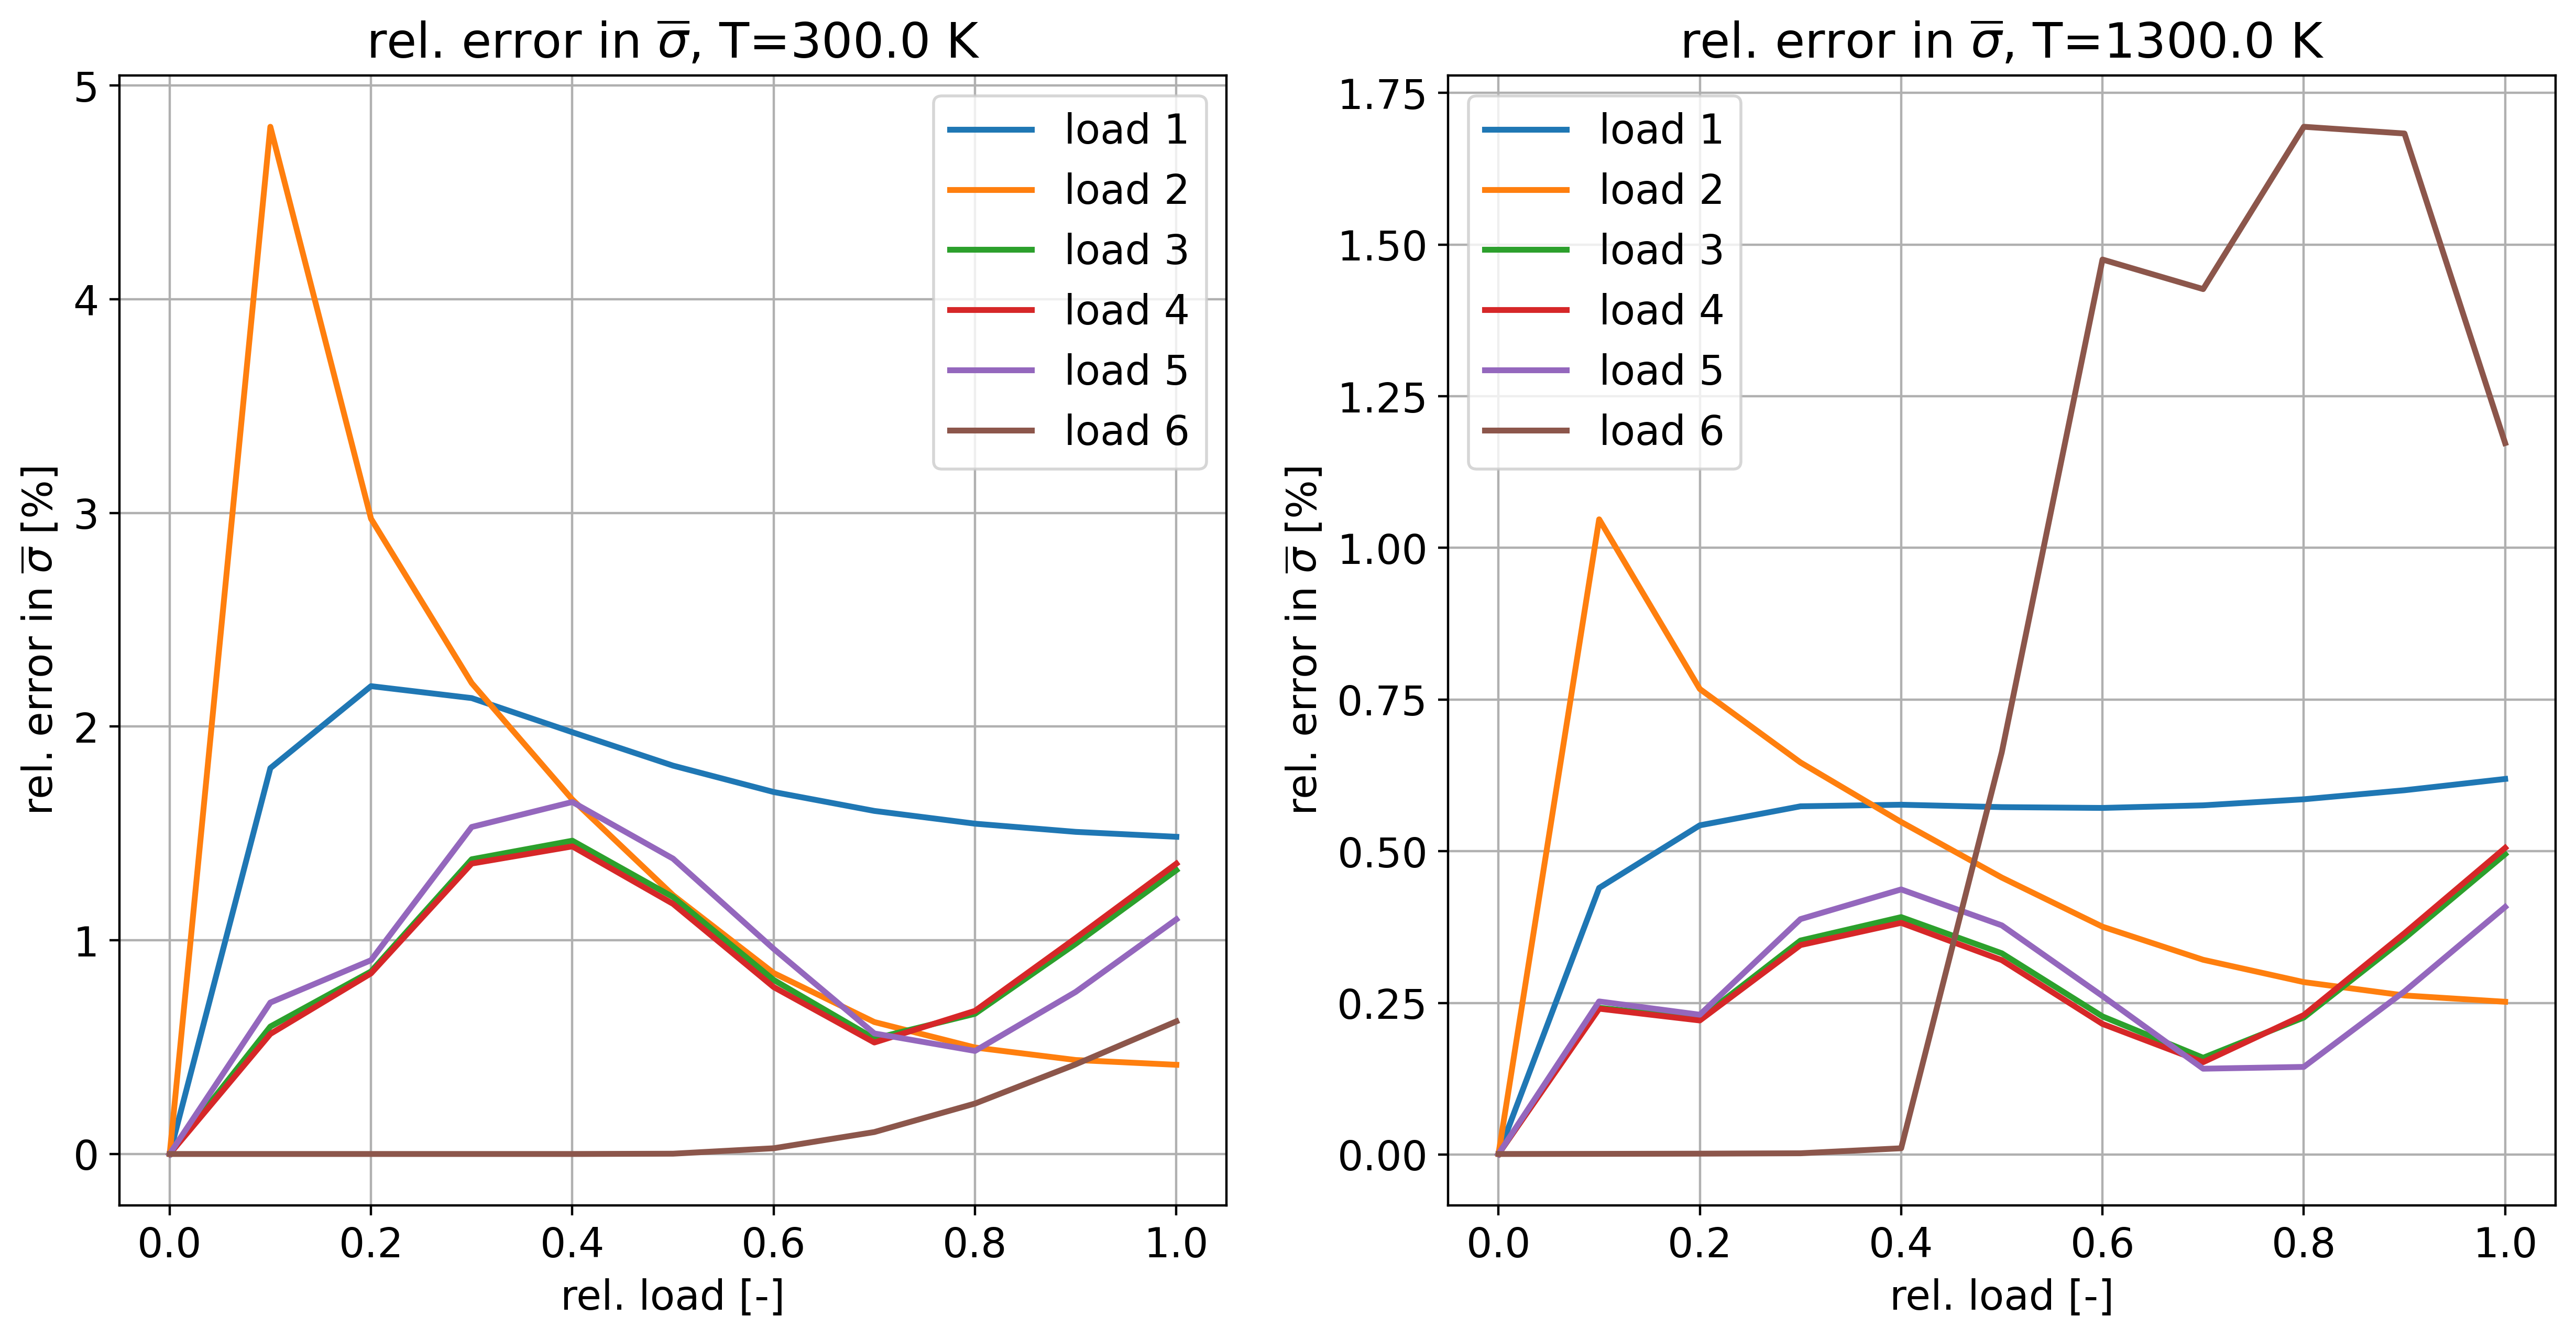

In [5]:
fig, axx = plt.subplots(1,2, figsize=(15,7))
ct=0
for i_T, T in zip( (0, 9), (300., 1300.)):
    ax = axx[ct]
    ct += 1
    ax.set_title( r'rel. error in $\overline{\sigma}$, T=%.1f K'% T)
    x = np.linspace(0,1,11)
    ax.set_xlabel('rel. load [-]')
    ax.set_ylabel(r'rel. error in $\overline{\sigma}$ [%]')
    for iload in range(6):
        myerr = np.linalg.norm( fans_sig[i_T][iload][:,:] - ntfa_sig[i_T][iload][:,:], axis=1) \
        *100./np.linalg.norm( fans_sig[i_T][iload][:,:], axis=1)
        ax.plot(x, myerr, lw=2, label=f'load {iload+1}')
        # print(np.max(myerr))
    ax.legend()
    ax.grid()
    # fig.savefig( f'rel_error_ms9p_T{T:.0f}.pdf', format='pdf', pad_inches=0.0)
plt.savefig(os.path.join("results", "rel_err_sig_10s.pdf"), format="pdf")

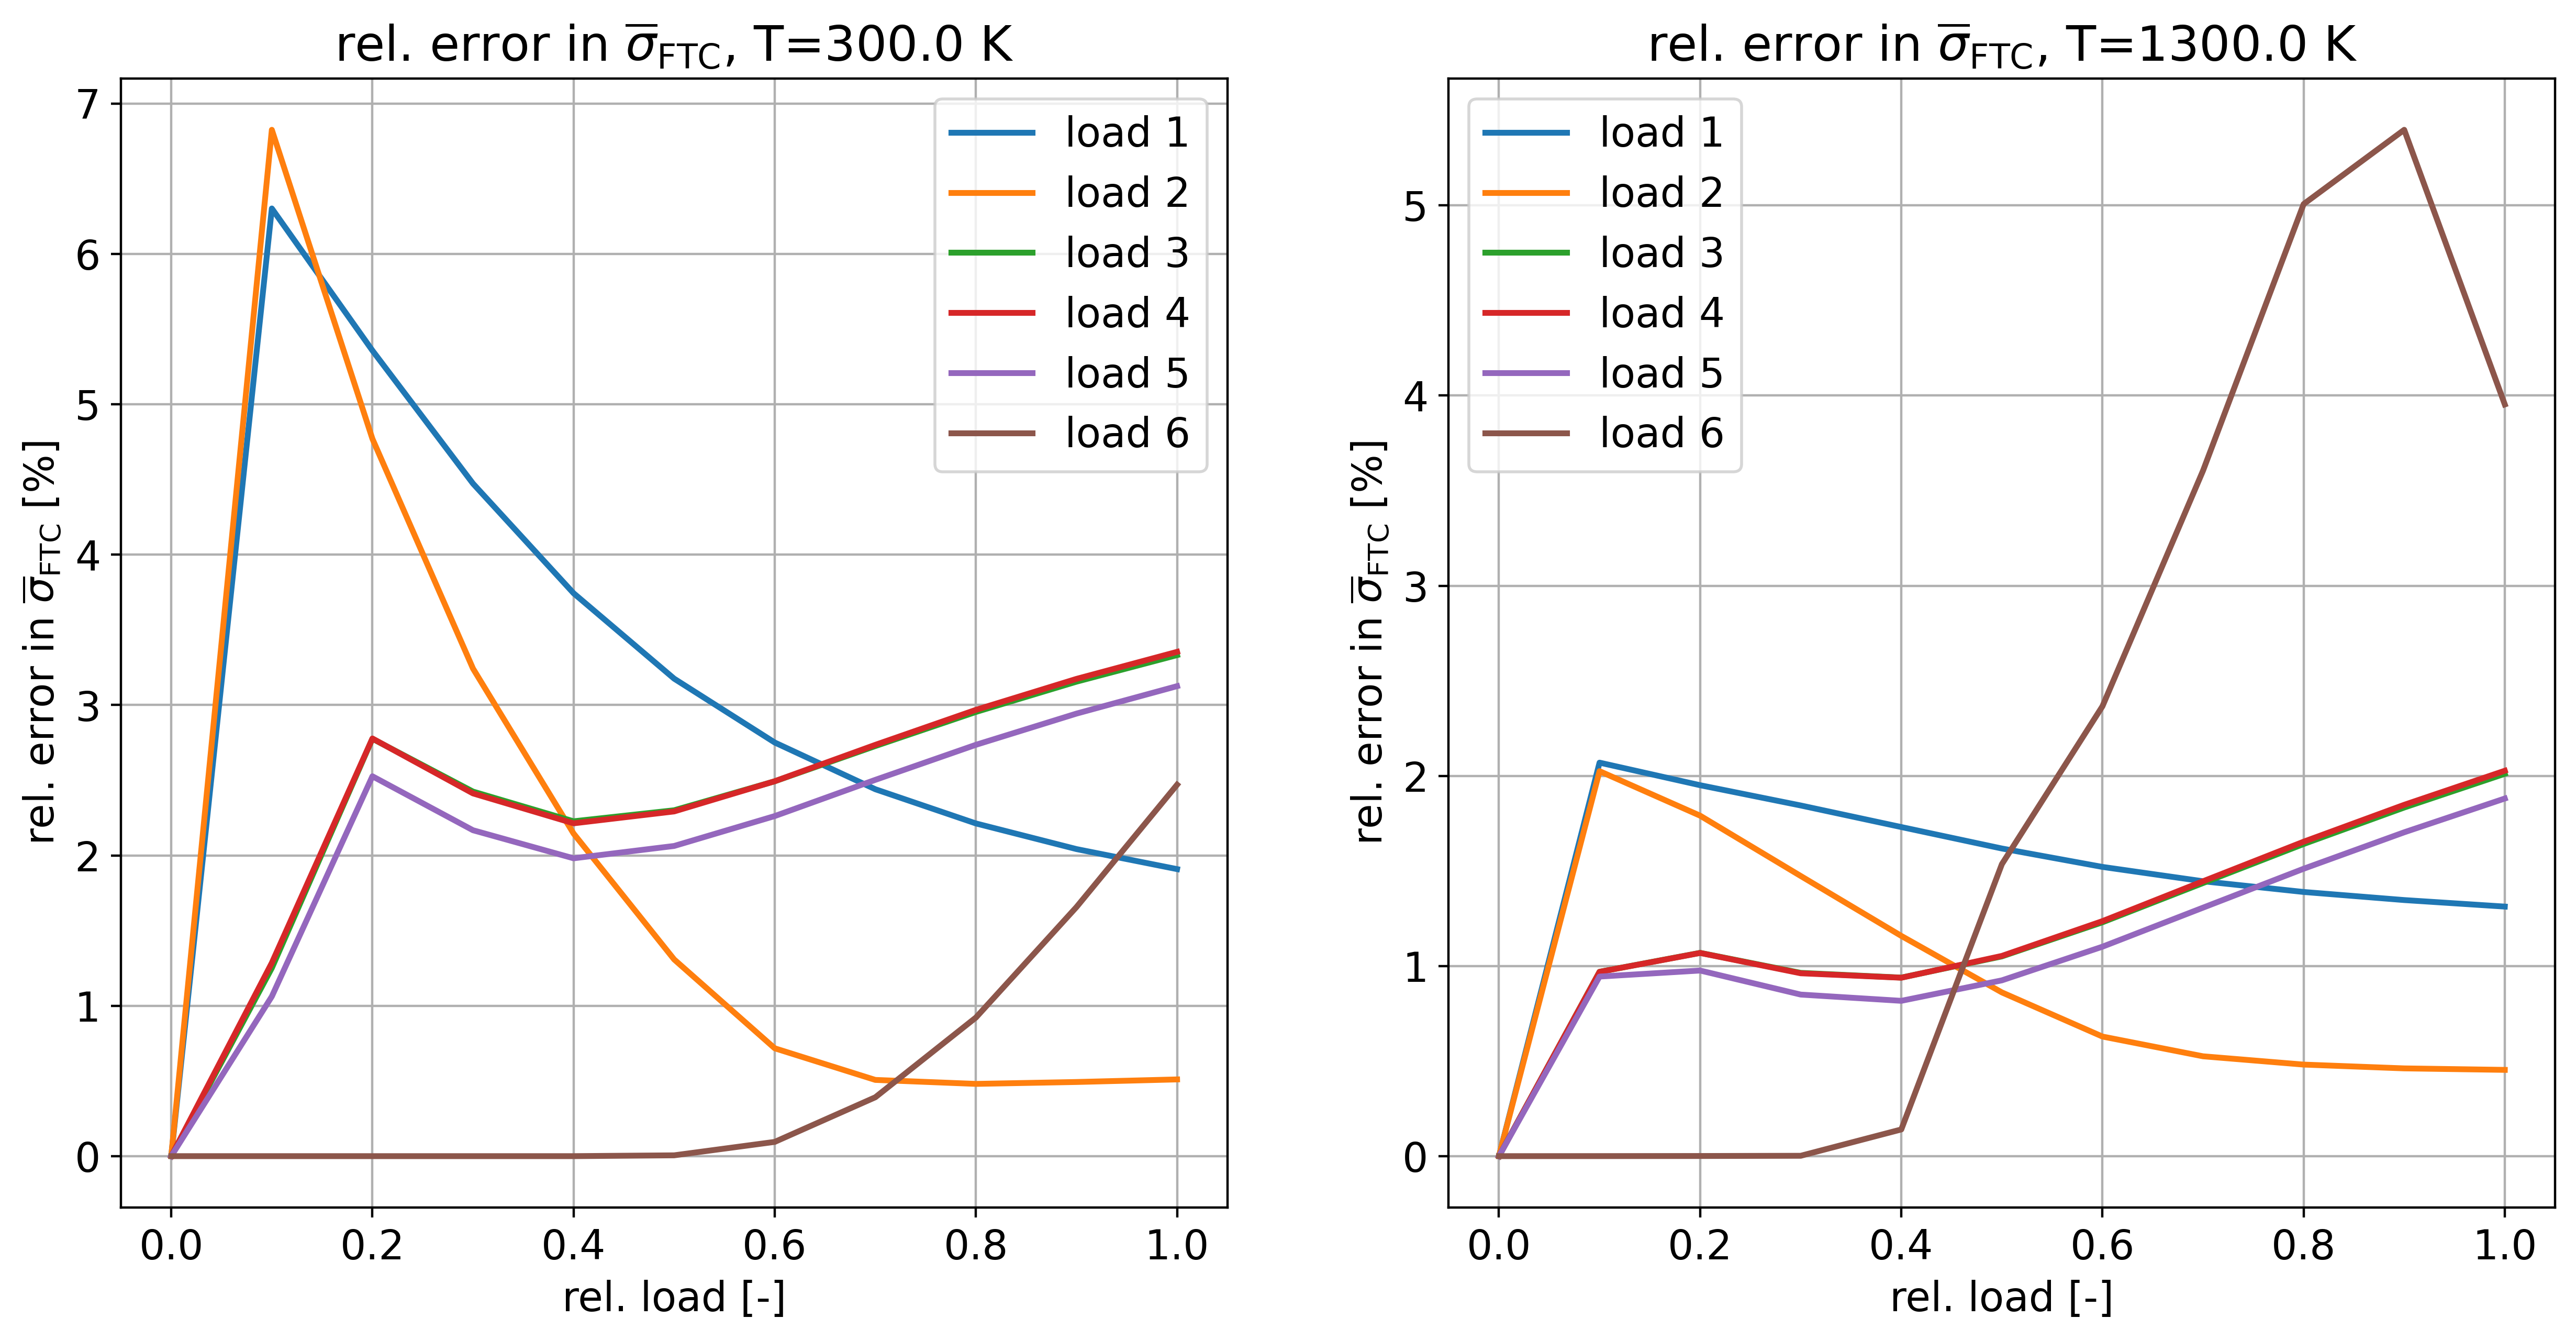

In [6]:
fig, axx = plt.subplots(1,2, figsize=(15,7))
ct=0
for i_T, T in zip( (0, 9), (300., 1300.)):
    ax = axx[ct]
    ct += 1
    ax.set_title( r'rel. error in $\overline{\sigma}_{\rm FTC}$, T=%.1f K'% T)
    x = np.linspace(0,1,11)
    ax.set_xlabel('rel. load [-]')
    ax.set_ylabel(r'rel. error in $\overline{\sigma}_{\sf FTC}$ [%]')
    for iload in range(6):
        myerr = np.linalg.norm( fans_sig_wsc[i_T][iload][:,:] - ntfa_sig_wsc[i_T][iload][:,:], axis=1) \
        *100./np.linalg.norm( fans_sig_wsc[i_T][iload][:,:], axis=1)
        # myerr[0] = 0.
        ax.plot(x, myerr, lw=2, label=f'load {iload+1}')
    ax.legend()
    ax.grid()
    # fig.savefig( f'rel_error_ms9p_T{T:.0f}.pdf', format='pdf', pad_inches=0.0)
plt.savefig(os.path.join("results", "rel_err_sig_ftc_10s.pdf"), format="pdf")

### Plot the for loadcase no. 2 relevant curves

In [7]:
err = np.zeros((theta.size, fans_sig.shape[2]))
err0 = np.zeros_like(err)
err1 = np.zeros_like(err)
err_h = np.zeros_like(err)
err_eq = np.zeros_like(err)
zeta = np.zeros((eps.shape[2], ntfa_xi.shape[-1]+7))
iload = 2
for i_T, T in enumerate(theta):
    Sref = fans_sig[i_T,iload]
    Sref0 = fans_sig_cu[i_T,iload]
    Sref1 = fans_sig_wsc[i_T,iload]
    # recompute stress of NTFA:
    zeta[:,:6] = eps[i_T,iload]
    zeta[:,6] = 1
    zeta[:,7:] = ntfa_xi[i_T,iload]
    ntfa_S0 = zeta @ (A_cu.interpolate(T)).T
    ntfa_S1 = zeta @ (A_wsc.interpolate(T)).T
    dS = Sref - ntfa_sig[i_T,iload,:,:]
    dS0 = Sref0 - ntfa_S0
    dS1 = Sref1 - ntfa_S1
    # dS0 = Sref0 - ntfa_sig_cu[i,iload,:,:]
    # dS1 = Sref1 - ntfa_sig_wsc[i,iload,:,:]
    # errors in %
    err[i_T,:] = np.linalg.norm(dS,axis=1)/np.linalg.norm(Sref,axis=1) * 100
    err0[i_T,:] = np.linalg.norm(dS0,axis=1)/np.linalg.norm(Sref0,axis=1) * 100
    err1[i_T,:] = np.linalg.norm(dS1,axis=1)/np.linalg.norm(Sref1,axis=1) * 100
    # in MPa:
    err_h[i_T,:] = dS[:,:3].sum(axis=1)/3. / 1000.
    err_eq[i_T,:] = np.maximum( 0, np.linalg.norm(dS,axis=1)**2 - 3*err_h[i_T,:]**2 ) * np.sqrt(1.5) / 1000.

### 3D Plots

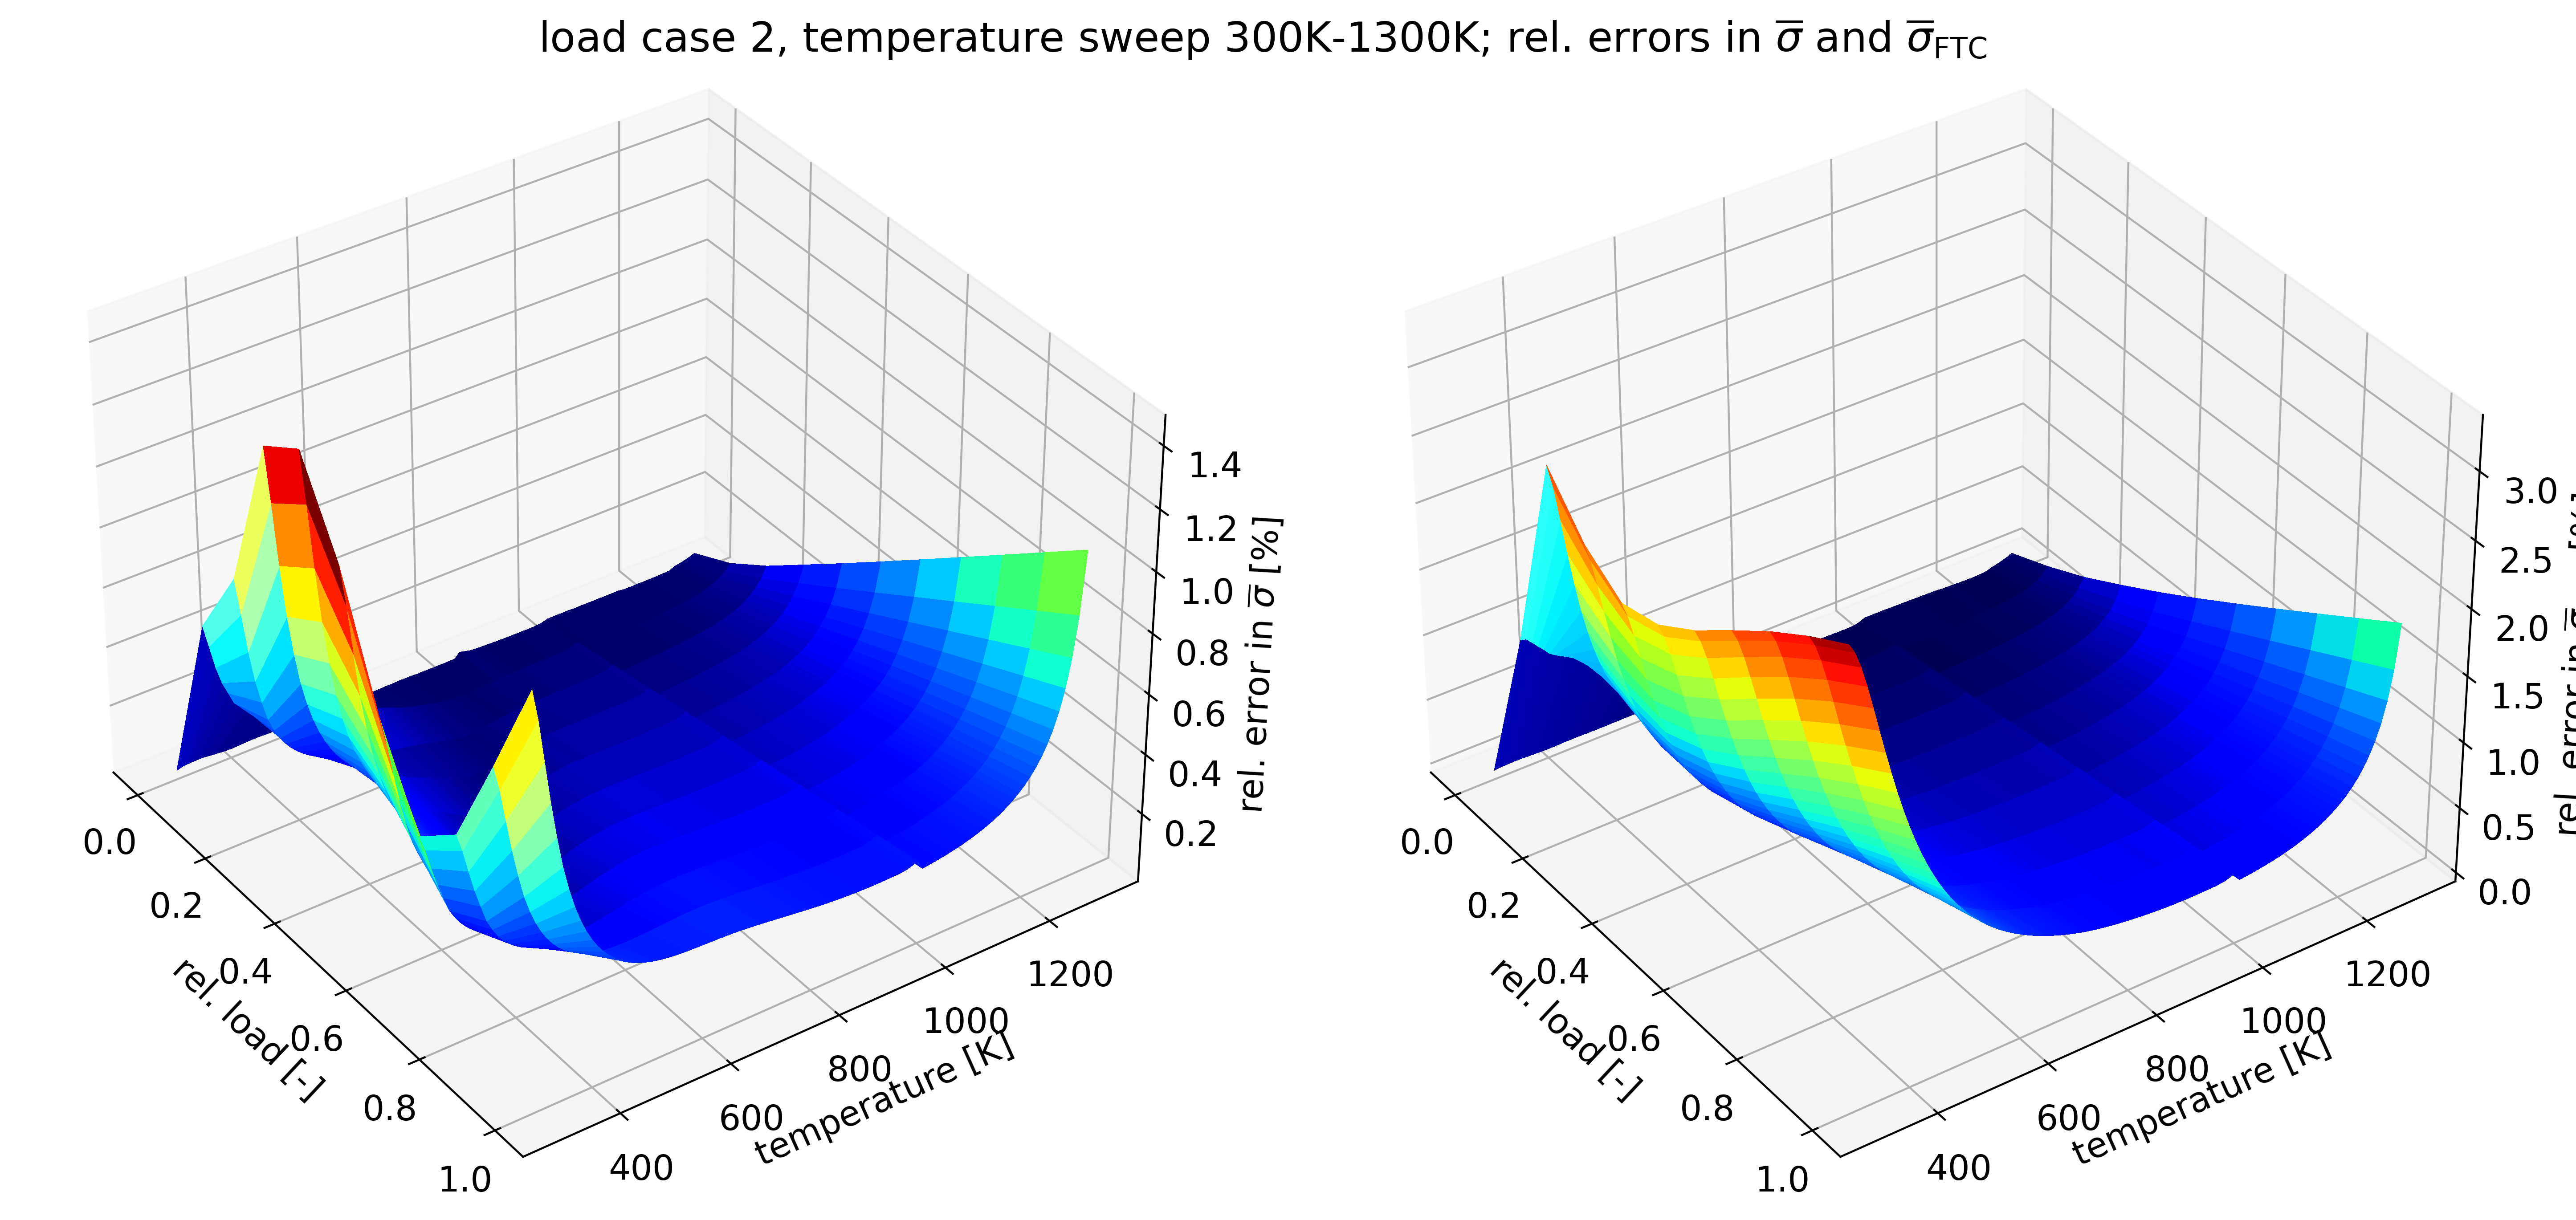

In [8]:
X = np.linspace(0,1,fans_sig.shape[2])
Y = theta
XX, YY = np.meshgrid(X, Y)


fig, axx = plt.subplots(1,2,subplot_kw=dict(projection='3d'),figsize=(15,7))


ax=axx[0]

ls = LightSource(220, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
ZZ = err
rgb = ls.shade(ZZ, cmap=cm.jet, vert_exag=0.1, blend_mode='soft')
ax.view_init(elev=35, azim=-35)
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False)

ax.set_xlabel("rel. load [-]")
ax.set_ylabel("temperature [K]")
ax.set_zlabel(r"rel. error in $\overline{\sigma}$ [%]")


ax=axx[1]

ls = LightSource(220, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
ZZ = err1
rgb = ls.shade(ZZ, cmap=cm.jet, vert_exag=0.1, blend_mode='soft')
ax.view_init(elev=35, azim=-35)
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False)

ax.set_xlabel("rel. load [-]")
ax.set_ylabel("temperature [K]")
ax.set_zlabel(r"rel. error in $\overline{\sigma}_{\sf FTC}$ [%]")

fig.tight_layout()
fig.suptitle(r"load case 2, temperature sweep 300K-1300K; rel. errors in $\overline{\sigma}$ and $\overline{\sigma}_{\sf FTC}$")
plt.savefig("surface_plots_err_sig_sig_ftc.pdf", format="pdf")

## Random loading

In [9]:
file_name = os.path.join("data", "ms9p_fix_ntfa16_B1-6_10s_N24.h5")
ntfa_material = ThermoMechNTFA(file_name, group_name='/', sigf=my_sigf, Nmax=24)

with h5py.File("random_loadings_vol1e-3_dev2e-2_paper_10increments.h5", "r") as F:
    # load the random loadings from file and run NTFA; compare to full model
    eps_rand = np.array(F["/eps_random"][:3, :])
    fig, ax = plt.subplots(2, 3, figsize=(15,10))
    for i_load, E in enumerate(eps_rand):
        for T in ('0355.6', '0688.9', '1022.2'):
            ntfa_e = np.zeros((11, 6))
            ntfa_s = np.zeros((11, 6))
            ntfa_s_ftc = np.zeros((11, 6))
            ntfa_xi = np.zeros((11, ntfa_material.n_modes))
            ntfa_q = np.zeros(11)
            theta = float(T)
            ntfa_material.Interpolate(theta)
            e = np.zeros(6)
            de = np.zeros(6)
            s = np.zeros(6)
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.
            i_inc = 0
            # initial purely thermal step:
            s, q, xi, C = ntfa_material.solve(e, de, theta, q, xi)
            ntfa_s[i_inc, :] = s
            ntfa_e[i_inc, :] = e
            ntfa_q[i_inc] = q
            ntfa_s_ftc[i_inc, :] = ntfa_material.stress(e, theta, xi, i_phase = 1)
            i_inc += 1
            print('# -----------------------------------------------------')
            print(f'# theta {theta:6.1f} K, load direction {E}')
            print(f'# q_initial = {100*q:6.2f}%')
            rel_load = np.linspace(0, 1, 11)
            for l in rel_load[1:]:
                e_old = e
                e = E*l
                de = e-e_old
                s, q, xi, C = ntfa_material.solve( e, de, theta, q, xi )
                ntfa_s[i_inc, :] = s
                ntfa_e[i_inc, :] = e
                ntfa_q[i_inc] = q
                ntfa_s_ftc[i_inc, :] = ntfa_material.stress(e, theta, xi, i_phase = 1)
                i_inc += 1
            s_ref = np.array(F[f'loading{i_load}/ntfa_T{T}/fe_sig'])
            s_ftc_ref = np.array(F[f'loading{i_load}/ntfa_T{T}/fe_sig1'])
            print('rel. error in sigma: ', rel_error(ntfa_s, s_ref))
            print('rel. error in sigma_FTC: ', rel_error(ntfa_s_ftc, s_ftc_ref))
            if( i_load == 0 ):
                ax[0, i_load].plot( rel_load, rel_error(ntfa_s, s_ref)*100, label=fr'$\theta$={theta}')
            else:
                ax[0, i_load].plot( rel_load, rel_error(ntfa_s, s_ref)*100)
            ax[0, i_load].set_ylabel(r'rel. error in $\overline{\sigma}$ [%]')
            ax[0, i_load].set_xlabel(r'rel. loading [-]')
            ax[1, i_load].set_ylabel(r'rel. error in $\overline{\sigma}_{\sf FTC}$ [%]')
            ax[1, i_load].set_xlabel(r'rel. loading [-]')
            ax[1, i_load].plot( rel_load, rel_error(ntfa_s_ftc, s_ftc_ref)*100)
    for a in ax:
        fig.legend()
    fig.tight_layout()

NameError: name 'my_sigf' is not defined

## Uniaxial stress-driven simulation

In [ ]:
theta_list =  np.linspace(300, 1300, 5)
eps_list = []
sig_list = []
sig0_list = []
sig1_list = []
q_list = []
xi_list = []

ntfa_material = ThermoMechNTFA(
    'modes/ms9p_fix_ntfa16_B1-6_10s_N24.h5', '/', sigf=my_sigf, Nmax=24)

In [ ]:
# generate and store data
# uniaxial stress loading for all 6 directions
# starting from initial thermoelastic relaxed deformation state
with h5py.File("ms9p_uniaxial_stress_data_mod.h5", "w") as F:
    for iload in range(6):
        G = F.create_group(f"loading{iload:1d}")
        # part 1: theta ramp up in 1 step
        # part 2: add on top a uniaxial loading
        for theta in theta_list:
            eps_idx = np.array([iload,])
            sig_idx = np.setdiff1d(np.arange(6), eps_idx)
            eps = np.zeros(6)
            eps[eps_idx] = 1.
            eps = np.linspace(0, 0.02, 11)[:, None] * eps
            ntfa_material.Interpolate(theta)
            # relaxed thermo-elastic strain
            eps_th_el =  - np.linalg.solve(ntfa_material.C, ntfa_material.s_th )

            eps_initial, sig_initial, C_initial, q_initial, xi_initial = ntfa_material.UMAT_mixed(None, np.zeros(6), np.zeros(6),
                                                                        np.zeros(6), theta, 0., np.zeros(ntfa_material.n_modes))
            print("q_ini: ", q_initial, eps_initial-eps_th_el)
            eps = eps + eps_initial
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.
            C = np.zeros((6, 6))
            np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
            sig = np.zeros_like(eps)
            sig0 = np.zeros_like(eps)
            sig1 = np.zeros_like(eps)
            xi = np.zeros(( eps.shape[0], ntfa_material.n_modes) )
            q = np.zeros(eps.shape[0])
            q_n = 0
            xi_n = np.zeros(ntfa_material.n_modes)
            for i in range(eps.shape[0]):

                if( i == 0 ):
                    deps = eps[0].copy()
                    eps_n = np.zeros(6)
                else:
                    deps = eps[i] - eps[i-1]
                    eps_n = eps[i-1]
                eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
                    eps_idx, eps_n, deps, np.zeros(6), theta, q_n, xi_n)
                xi_n = xi[i].copy()
                q_n = q[i]
                sig0[i] = ntfa_material.stress(eps[i], theta, xi[i], i_phase=0)
                sig1[i] = ntfa_material.stress(eps[i], theta, xi[i], i_phase=1)
                # if( i==0 ):
                #     eps_th_el = np.zeros(6)
                #     eps_th_el = - np.linalg.solve(ntfa_material.C, ntfa_material.s_th )
                #     # eps_th_el[sig_idx] = - np.linalg.solve(ntfa_material.C[sig_idx,:][:,sig_idx], ntfa_material.s_th[sig_idx] )
                #     print( f"theta: {theta:6.1f} -- ", (eps[i] - eps_th_el), q[i] )
                # print(f'{i:3d} - {sig[i]} - {q[i]:6.4f}')
            # print("after:  ", eps[0], q[0])
           # print(eps)
            eps_list.append(eps)
            sig_list.append(sig)
            sig0_list.append(sig0)
            sig1_list.append(sig1)
            xi_list.append(xi)
            q_list.append(q)
            # print(f"ntfa_T{theta:06.1f}")
            GG = G.create_group(f"ntfa_T{theta:06.1f}")
            GG.create_dataset("eps", data=eps)
            GG.create_dataset("sig", data=sig)
            GG.create_dataset("sig0", data=sig0)
            GG.create_dataset("sig1", data=sig1)
            GG.create_dataset("q", data=q)
            GG.create_dataset("xi", data=xi)

In [ ]:
# run uniaxial strain controlled tests at different temperatures
# the initial state is gained by ramping up the temperature from 293 K
# subsequently, a strain controlled loading is superimposed in the iload-th
# component (2% loading).


theta_list =  np.linspace(300, 1300, 5)
eps_list = []
sig_list = []
sig0_list = []
sig1_list = []
q_list = []
xi_list = []
n_ramp = 10
with h5py.File("ms9p_uniaxial_stress_data_mod.h5", "w") as F:
    for iload in range(6):
        G = F.create_group(f"loading{iload:1d}")
        # part 1: theta ramp up in 5 steps
        # part 2: add on top a uniaxial loading
        for theta in theta_list:
            eps_idx = np.array([iload,])
            sig_idx = np.setdiff1d(np.arange(6), eps_idx)
            eps = np.zeros(6)
            eps[eps_idx] = 1.
            # the actual loading we are seeking:
            eps_bc = np.zeros((10 + n_ramp, 6))
            eps_bc[(n_ramp-1):, eps_idx] = np.linspace(0, 0.02, 11)[:, None]

            # part 1: ramp up theta from 293 K to theta
            T = np.zeros(n_ramp+10)
            theta_ramp = np.linspace(293.0, theta, n_ramp)
            T[:n_ramp] = theta_ramp
            T[n_ramp:] = theta


            # ntfa_material.A@eps[0] + ntfa_material.t_xi,
            # print("tau_initial: ",  np.linalg.norm( ntfa_material.A@eps[0] + ntfa_material.t_xi), ";  sig_f: ", ntfa_material.sigf(theta,0.,False) * np.sqrt(2./3.) * ntfa_material.v_frac[0])
            # print("before: ", eps[0])
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.
            C = np.zeros((6, 6))
            np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
            eps = np.zeros_like(eps_bc)
            sig = np.zeros_like(eps)
            sig0 = np.zeros_like(eps)
            sig1 = np.zeros_like(eps)
            xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
            q = np.zeros(eps.shape[0])
            q_n = 0.
            xi_n = np.zeros(ntfa_material.n_modes)
            for i in range(eps.shape[0]):
                t = T[i]
                if (i == 0):
                    deps = eps_bc[0].copy()
                    eps_n = np.zeros(6)
                else:
                    deps = eps_bc[i] - eps[i-1]
                    eps_n = eps[i-1]
                if (i < n_ramp):
                    # this induces stress free loading with free strains
                    eps_idx = None
                else:
                    eps_idx = np.array([iload,])
                eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
                    eps_idx, eps_n, deps, np.zeros(6), t, q_n, xi_n)
                xi_n = xi[i].copy()
                q_n = q[i]
                sig0[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=0)
                sig1[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=1)
                # print(t, eps[i], q[i])
                if (i == n_ramp-1):
                    # update the BC!
                    eps_bc[n_ramp:, :] += eps[n_ramp-1][None, :]
                    # print(t, eps[i], q[i])
                # if( i==0 ):
                #     eps_th_el = np.zeros(6)
                #     eps_th_el = - np.linalg.solve(ntfa_material.C, ntfa_material.s_th )
                #     # eps_th_el[sig_idx] = - np.linalg.solve(ntfa_material.C[sig_idx,:][:,sig_idx], ntfa_material.s_th[sig_idx] )
                #     print( f"theta: {theta:6.1f} -- ", (eps[i] - eps_th_el), q[i] )
                # print(f'{i:3d} - {sig[i]} - {q[i]:6.4f}')
            # print("after:  ", eps[0], q[0])
            # print(eps)
            eps_list.append(eps)
            sig_list.append(sig)
            sig0_list.append(sig0)
            sig1_list.append(sig1)
            xi_list.append(xi)
            q_list.append(q)
            # print(f"ntfa_T{theta:06.1f}")
            GG = G.create_group(f"ntfa_T{theta:06.1f}")
            GG.create_dataset("T", data=T)
            GG.create_dataset("eps", data=eps)
            GG.create_dataset("sig", data=sig)
            GG.create_dataset("sig0", data=sig0)
            GG.create_dataset("sig1", data=sig1)
            GG.create_dataset("q", data=q)
            GG.create_dataset("xi", data=xi)

In [ ]:
#%% Figuring when palsticity kicks in using the mixed UMAT
# 1. set the stress to 0
# 2. ramp the temperature from 293K
# 3. check for q >= q_crit_0, q_crit_1, ...
#    e.g. q_crit_0 = 0.002 (i.e. 0.2%)
# draw the results of theta

n_ramp = 1300-293+1
with h5py.File("ms9p_thermal_rampup.h5", "w") as F:
    eps_idx = None
    sig_idx = np.arange(6)
    eps = np.zeros(6)
    # the actual loading we are seeking:
    eps_bc = np.zeros((n_ramp, 6))

    # part 1: ramp up theta from 293 K to theta
    T = np.linspace(293.0, 1300.0, n_ramp)
    q = 0.
    C = np.zeros((6, 6))
    np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
    eps = np.zeros_like(eps_bc)
    sig = np.zeros_like(eps)
    sig0 = np.zeros_like(eps)
    sig1 = np.zeros_like(eps)
    xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
    q = np.zeros(eps.shape[0])
    q_n = 0.
    xi_n = np.zeros(ntfa_material.n_modes)
    for i in range(eps.shape[0]):
        t = T[i]
        if (i == 0):
            deps = eps_bc[0].copy()
            eps_n = np.zeros(6)
        else:
            deps = eps_bc[i] - eps[i-1]
            eps_n = eps[i-1]
        eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
            eps_idx, eps_n, deps, np.zeros(6), t, q_n, xi_n)
        xi_n = xi[i].copy()
        q_n = q[i]
        sig0[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=0)
        sig1[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=1)
        # print(t, eps[i], q[i])
    # print(f"ntfa_T{theta:06.1f}")
    F.create_dataset("T", data=T)
    F.create_dataset("eps", data=eps)
    F.create_dataset("sig", data=sig)
    F.create_dataset("sig0", data=sig0)
    F.create_dataset("sig1", data=sig1)
    F.create_dataset("q", data=q)
    F.create_dataset("xi", data=xi)

#%%
q_crit = [ 1e-5, 0.002, 0.005, 0.01 ]
with h5py.File("ms9p_thermal_rampup.h5", "r") as F:
    q = np.array(F["q"])
    T = np.array(F["T"])
    eps = np.array(F["eps"])
    sig0 = np.array(F["sig0"])
    sig1 = np.array(F["sig1"])
    fig, ax = plt.subplots(1,1,figsize=(12,7))
    ax.plot(T, 100*q, color='red', lw=2, label=r'NTFA $\overline{q}$')
    for qc in q_crit:
        ax.plot([T[0], T[-1]], [100*qc, 100*qc], color='black', lw=1)
        i = np.searchsorted(q, qc)
        ax.annotate(text=f'$q_c={qc*100}\%, T={T[i]}K$', xy=[T[i], 100*q[i]],
                    xytext=[T[i]-150, 100*q[i]+0.2], color='blue',
                    arrowprops = dict( width=2 ) )

ax.grid()
ax.set_xlim(T[0], T[-1])
ax.set_xlabel(r"temperature $T$ [K]")
ax.set_ylabel(r"hardening variable $\overline{q}$ [%]")

#%%



sig_fe_list = []
sig0_fe_list = []
sig1_fe_list = []

# with h5py.File("ms9p_uniaxial_stress_data_loading0-5.h5", "r") as F:
with h5py.File("ms9p_uniaxial_stress_data_mod_loading0.h5", "r") as F:
    for iload in range(1):
        G = F[f"loading{iload:1d}"]
        for theta in theta_list:
            GG = G[f"ntfa_T{theta:06.1f}"]
            sig_fe = np.array(GG["fe_sig"])
            sig0_fe = np.array(GG["fe_sig0"])
            sig1_fe = np.array(GG["fe_sig1"])
            sig_fe_list.append(sig_fe)
            sig0_fe_list.append(sig0_fe)
            sig1_fe_list.append(sig1_fe)


def rel_error(A, A_ref, r_min=None):
    if(r_min is None):
        return np.linalg.norm(A-A_ref, axis=1)/np.linalg.norm(A_ref, axis=1)
    else:
        return np.linalg.norm(A-A_ref, axis=1) / \
            (np.maximum(r_min, np.linalg.norm(A_ref, axis=1)))



n = len(sig_fe_list)

for k in [0, 1, 2, 3, 4]:
    fig, ax = plt.subplots(1, 2, figsize=(8,4.5))
    # fig.suptitle(rf"$T={theta_list[np.mod(k,5)]}$ - rel. error (overall/matrix/inclusion)")
    temp = theta_list[np.mod(k,5)]
    fig.suptitle(rf"$T={temp}$ - rel. error (matrix/inclusion)")
    c1 = ntfa_material.v_frac[0]
    c2 = ntfa_material.v_frac[1]
    sig_list[k] = c1 * sig0_list[k] + c2 * sig1_list[k]
    # delta =   c1 * sig0_list[k] + c2 * sig1_list[k] - sig_list[k]
    # print(rel_error(  c1 * sig0_fe_list[k] + c2 * sig1_fe_list[k], sig_fe_list[k] ))
    err_sig = rel_error(sig_list[k], sig_fe_list[k], r_min=1e4)
    err_sig0 = rel_error(sig0_list[k], sig0_fe_list[k], r_min=1e4)
    err_sig1 = rel_error(sig1_list[k], sig1_fe_list[k], r_min=1e4)
    t = np.linspace(0, 1, sig_list[k].shape[0])
    ax[0].plot(t[:], err_sig0[:]*100)
    ax[1].plot(t[:], err_sig1[:]*100)
    for A in ax:
        A.grid()
        A.set_xlabel('rel. time [-]')
        A.set_ylabel('rel. error [%]')
        A.set_ylim([0, 10])
    ax[0].text(.55, 1, 'plastic matrix', backgroundcolor='#004191', color='white')
    ax[1].text(.55, 1, 'elastic particles', backgroundcolor='#004191', color='white')
    fig.tight_layout()
    plt.savefig(f'rel_error_uniaxial_T{temp:.0f}.jpg')
    # ax[0].plot(t[:], err_sig[:]*100)
    # ax[1].plot(t[:], err_sig0[:]*100)
    # ax[2].plot(t[:], err_sig1[:]*100)

    # print( sig_list[k] - ntfa_material.v_frac[0] * sig0_list[k] - ntfa_material.v_frac[1] * sig1_list[k] )
    # print(f'rel. error in sig   {100*err_sig}%')
    # print(f'rel. error in sig0  {100*err_sig0}%')
    # print(f'rel. error in sig1  {100*err_sig1}%')

## Twoscale simulation

In [ ]:
#%% Analysis of the two-scale simulation
"""##############################################################################
# Analysis of the two-scale simulation
# - determine an element in the notch
# - extract the strain, temperature, stress, qbar, xi, sig_cu, sig_wsc history
# - pass the strain, temperature history to FANS as BC
# - Compare the results
##############################################################################"""
with h5py.File("vtk_notch/NTFA293K_fine_temp_293-800.h5", "r") as F:

    # step 1: find the element with the crucial pieces of information
    # read mesh
    vx = np.array(F["/mesh/X"]).reshape((-1,3))
    el = np.array(F["/mesh/el_vx_idx"]).reshape((-1,10))
    n_el = np.array(F["/mesh/n_el"])[0]
    n_vx = np.array(F["/mesh/n_vx"])[0]
    gp_idx = np.array(F["/mesh/DPIdx"])

    # get element centers
    el_center = np.zeros((n_el,3))
    for i_el in range(n_el):
        el_center[i_el,:] = np.mean( vx[el[i_el,:],:], axis=0 )

    # find the element center closest to 0., 2.5, 0.
    dist = np.linalg.norm(el_center - np.array([5.,0,2.5])[None,:], axis=1)
    i_min = np.argmin(dist)
    print(f"element closest to [5., 0., 2.5]: {i_min} with element center {el_center[i_min]}")

In [ ]:
#%% Read the history for the integration point of interest
# vicinity of the noth (at the center of the specimen)
with h5py.File("vtk_notch/NTFA293K_fine_temp_293-800.h5", "r") as F:
    N_modes = 24
    n_inc = 32
    theta = np.zeros(n_inc+1)
    eps = np.zeros((n_inc+1,6))
    sig = np.zeros((n_inc+1,6))
    sig_cu = np.zeros((n_inc+1,6))
    sig_wsc = np.zeros((n_inc+1,6))
    qbar = np.zeros(n_inc+1)
    xi = np.zeros((n_inc+1,N_modes))
    zeta = np.zeros((n_inc+1,N_modes+7))
    idat_start = np.array(F["/Data/step1/n_iD"][:gp_idx[i_min]]).sum()
    idat_end = idat_start + F["/Data/step1/n_iD"][gp_idx[i_min]]
    n_gp = F["/Data/step1/n_gp"][0]
    theta = np.array(F[f"/temperature{n_inc}"])
    force = np.array(F[f"/force{n_inc}"])
    for i in range(n_inc):
        j = i+1
        cdat = np.array( F[f"/Data/step{i+1}/cData"][gp_idx[i_min]])
        eps[j,:] = cdat[:6]
        sig[j,:] = cdat[6:]
        idat = np.array( F[f"/Data/step{i+1}/iData"])[idat_start:idat_end]
        xi[j,:] = idat[1:(N_modes+1)]
        qbar[j] = idat[0]
        zeta[j,:6] = eps[j,:]
        zeta[j,6] = 1
        zeta[j,7:] = xi[j,:]
        # reconstruct the phase-wise stresses
        sig_cu[j,:] = A_cu.Interpolate(theta[j]) @ zeta[j,:]
        sig_wsc[j,:] = A_wsc.Interpolate(theta[j]) @ zeta[j,:]

#%% some plots
# compute some stress information
sig_h = sig[:,:3].sum(axis=1)/3
sig_h_cu = sig_cu[:,:3].sum(axis=1)/3
sig_h_wsc = sig_wsc[:,:3].sum(axis=1)/3
sig_eq = np.sqrt( 1.5 * np.maximum( 0.0, np.linalg.norm(sig, axis=1)**2 - 3*sig_h*sig_h) )
sig_eq_cu = np.sqrt( 1.5 * np.maximum( 0.0, np.linalg.norm(sig_cu, axis=1)**2 - 3*sig_h_cu*sig_h_cu) )
sig_eq_wsc = np.sqrt( 1.5 * np.maximum( 0.0, np.linalg.norm(sig_wsc, axis=1)**2 - 3*sig_h_wsc*sig_h_wsc) )
sig_I_wsc = np.zeros(sig.shape[0])
sig_II_wsc = np.zeros(sig.shape[0])
sig_III_wsc = np.zeros(sig.shape[0])
sig_I_cu = np.zeros(sig.shape[0])
sig_II_cu = np.zeros(sig.shape[0])
sig_III_cu = np.zeros(sig.shape[0])
for i in range(n_inc+1):
    sig_III_cu[i], sig_II_cu[i], sig_I_cu[i] = np.linalg.eigvalsh( Vec2Tensor(sig_cu[i]))
    sig_III_wsc[i], sig_II_wsc[i], sig_I_wsc[i] = np.linalg.eigvalsh( Vec2Tensor(sig_wsc[i]))


In [ ]:
t = np.linspace(0, 2, n_inc+1)
fig, ax = plt.subplots(1,2, dpi=dpi, figsize=(15,5))
ax[0].plot(eps[:,1], sig[:,1]/1000, color='black', label=r"$\overline{\sigma}_{\sf yy}$")
ax[0].plot(eps[:,1], sig_cu[:,1]/1000, '--', color='red', label=r"$\overline{\sigma}_{\sf Cu, yy}$")
ax[0].plot(eps[:,1], sig_wsc[:,1]/1000, '-.', color='blue', label=r"$\overline{\sigma}_{\sf WSC, yy}$")
ax[0].set_title(r"$\overline{\sigma}_{\sf yy}$, $\overline{\sigma}_{\sf Cu, yy}$, $\overline{\sigma}_{\sf WSC, yy}$ vs. $\overline{\varepsilon}_{\sf yy}$")
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel(r"$\overline{\varepsilon}_{\sf yy}$ [-]")
ax[0].set_ylabel(r"$\overline{\sigma}_{\sf yy}, \overline{\sigma}_{\sf Cu, yy}, \overline{\sigma}_{\sf WSC, yy}$ [MPa]")
eyy_max = max(eps[:,1])
syy = sig[int(n_inc/2),1]/1000
syy_cu = sig_cu[int(n_inc/2),1]/1000
syy_wsc = sig_wsc[int(n_inc/2),1]/1000
# arrowprops = dict(shrink=0.02, facecolor='black', shrinkB=1, width=2, headwidth=12, headlength=12)
arrowprops = dict(arrowstyle='-|>',  shrinkB=1, shrinkA=50)
# ax[0].annotate("start\nunloading &\ncool down", xy=(eyy_max,syy), xytext=(0.02,925), arrowprops=arrowprops)
ax[0].annotate("", xy=(eyy_max,syy_cu), xytext=(0.0275,975), arrowprops=arrowprops)
# ax[0].annotate("", xy=(eyy_max,syy_wsc), xytext=(0.0315,1050), arrowprops=arrowprops)
# ax[0].plot(eyy_max, syy_cu, 'd', color='red',ms=10)
# ax[0].plot(eyy_max, syy_wsc, 'd', color='blue',ms=10)
# ax[0].plot(eyy_max, syy, 'd', color='black',ms=10)

# ax[1].plot((1, 1), (-100,900), lw=2, color='gray' )
# ax[1].text( 1.05, -140, "Entlastung\n& Abkühlung")
# ax[1].annotate( "", xy=(1.25,0), xytext=(1,0), arrowprops=dict(facecolor='black', shrink=0.0, width=2, headwidth=12, headlength=12))
# ax[1].plot(t, sig[:,1]/1000, color='black', label=r"$\overline{\sigma}_{\sf yy}$")
# ax[1].plot(t, sig_cu[:,1]/1000, '--', color='red', label=r"$\overline{\sigma}_{\sf Cu,yy}$")
# ax[1].plot(t, sig_wsc[:,1]/1000, '-.', color='blue', label=r"$\overline{\sigma}_{\sf WSC,yy}$")
# ax[1].set_title(r"$\overline{\sigma}_{\sf yy}$, $\overline{\sigma}_{\sf Cu, yy}$, $\overline{\sigma}_{\sf WSC, yy}$, $\overline{Q}$ vs. time $t$")
# ax2 = ax[1].twinx()
# ax[1].legend(loc='center right')
# ax[1].grid()
# ax2.plot(t, qbar, label=r"$\overline{Q}$", color='olive', lw=2)
# ax[1].set_xlabel(r"$t$ [s]")
# ax[1].set_ylabel(r"$\overline{\sigma}_{\sf yy}, \overline{\sigma}_{\sf Cu, yy}, \overline{\sigma}_{\sf WSC, yy}$  [MPa]")
# ax2.set_ylabel(r"$\overline{Q}$ [-]")
# plt.tight_layout()
# plt.savefig("notchtest_fine_sigyy_ntfa.pdf", format="pdf")

In [ ]:
#%%
fig, ax = plt.subplots(1, 2, dpi=400, figsize=(15,7))
ax[0].plot(t, sig_III_wsc/1000, '-.', color='blue', label=r"$\overline{\sigma}_{\sf WSC, 3}$")
ax[0].plot(t, sig_II_wsc/1000, '--', color='blue', label=r"$\overline{\sigma}_{\sf WSC, 2}$")
ax[0].plot(t, sig_I_wsc/1000, color='blue', label=r"$\overline{\sigma}_{\sf WSC, 1}$")
ax[0].plot(t, sig_III_cu/1000, '-.', color='red', label=r"$\overline{\sigma}_{\sf Cu, 3}$")
ax[0].plot(t, sig_II_cu/1000, '--', color='red', label=r"$\overline{\sigma}_{\sf Cu, 2}$")
ax[0].plot(t, sig_I_cu/1000, color='red', label=r"$\overline{\sigma}_{\sf Cu, 1}$")
ax[0].legend(ncol=1) #loc='center right')
ax[0].grid()
ax[0].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"Hauptnormalspannungen [MPa]")
ax[0].plot((1, 1), (-200,900), lw=2, color='gray' )
ax[0].text( 1.05, 275, "unload \n& cool down")
ax[0].annotate( "", xy=(1.25,400), xytext=(1,400), arrowprops=dict(facecolor='black', shrink=0.0, width=2, headwidth=12, headlength=12))


yield_cu = lambda x: (1.12133e+02 * x + 3.49810e+04 + 1.53393e+05 * np.tanh(
    (x / 1000 + -6.35754e-01) / -2.06958e-01))*(x < 1000) + 1200.*(x>=1000.0)

sig_y = np.zeros_like(t)
for i, T in enumerate(theta):
    sig_y[i] = yield_cu( theta[i] ) + 500000*qbar[i]


ax[1].plot((1, 1), (-100,900), lw=2, color='gray' )
ax[1].text( 1.05, 275, "Entlastung\n& Abkühlung")
ax[1].annotate( "", xy=(1.25,400), xytext=(1,400), arrowprops=dict(facecolor='black', shrink=0.0, width=2, headwidth=12, headlength=12))
# ax[1].plot(t, sig_h_cu/1000, '-', color='red', label=r"$\overline{\sigma}_{\sf Cu, h}$")
ax[1].plot(t, sig_eq_cu/1000, '-', color='red', label=r"$\overline{\sigma}_{\sf Cu, eq}$")
# ax[1].plot(t, sig_h_wsc/1000, '-', color='blue', label=r"$\overline{\sigma}_{\sf WSC, h}$")
ax[1].plot(t, sig_eq_wsc/1000, '-', color='blue', label=r"$\overline{\sigma}_{\sf WSC, eq}$")
ax[1].plot(t, sig_y/1000, '-', color='black', label=r"$\sigma_{\sf F}(\overline{Q})$")
ax[1].legend(ncol=1, loc='upper right')
ax[1].grid()
ax[1].set_xlabel(r"$t$ [s]")
ax[1].set_ylabel(r"Vergleichsspannung und Fließspannung [MPa]")
fig.tight_layout()
fig.savefig("notchtest_fine_sigeq_ntfa.pdf", format="pdf")

#%%

F = h5py.File("daten_kerbgrund.h5", "w")
F.create_dataset("/sig", data=sig)
F.create_dataset("/sig_cu", data=sig_cu)
F.create_dataset("/sig_wsc", data=sig_wsc)
F.create_dataset("/eps", data=eps)
F.create_dataset("/theta", data=theta)

F.create_dataset("/time", data=t)
F.close()
# ax2=ax[1].twinx()
# ax2.plot(t, eps[:,1], color='black')
# ax2.plot(t, qbar[:], color='red')
# ax1].plot(t, sig_cu[:,1]/1000, '--', color='red')
# ax2.plot(t, sig_wsc[:,1]/1000, '-.', color='blue')

# ax2.plot(eps[:,1], sig_cu[:,1]/1000, '--', color='red')
# ax2.plot(eps[:,1], sig_wsc[:,1]/1000, '-.', color='blue')

In [ ]:

dpi = 400
force = []
temp = []
for s in ('coarse', 'medium', 'fine'):
    with h5py.File(f"vtk_notch/NTFA293K_{s}_temp_293-800.h5", mode="r") as F:
        force.append(np.array(F["force32"])/1e6)
        temp.append(np.array(F["temperature32"]))

fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=(7.5,5))
labels = False
for f, T in zip((force), (temp)):
    t = np.linspace(0, 2, f.size)
    ax.plot(t, f, '-s', ms=4, label='tensile force', color='blue')
    if( labels ):
        ax.plot(1.0, f[np.where(t==1.0)], 'o', color='black', ms=6)
    else:
        ax2 = ax.twinx()
        nhalf = int( (t.size+1)/2)
        # ax.plot(1.0, f[np.where(t==1.0)], 'o', color='black', ms=6, label='start unloading', zorder=4)
        ax.fill_between( t[:nhalf], f[:nhalf], np.zeros(nhalf), color='blue', alpha=0.2, zorder=2)
        ax.fill_between( t[(nhalf-1):], f[(nhalf-1):], np.zeros(f.size-nhalf+1), color='red', alpha=0.2, zorder=2)
        ax2.plot(t, T, '-s', ms=4, color='red', zorder=4, label='temperature')
        ax.set_xlabel('time [s]')
        ax.set_ylabel('force [kN]')
        ax2.set_ylabel('temperature [K]')
        ax.text(0.4, 2, 'tensile loading', color='blue', bbox=dict(facecolor='white'))
        ax.text(1.1, 2, 'force unloading', color='red', bbox=dict(facecolor='white'))
        ax.grid(zorder=1)
        ax.legend(loc=(0.65,0.825))
        ax2.legend(loc=(0.65,0.7))
    nhalf=int((t.size+1)/2)
    labels = True
fig.savefig('twoscale_loading.pdf')

#%%
fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=(7.5,5))
ax.plot((1., 1.), (-0.05, 1.05), '--', color='gray', lw=2, zorder=4)
ax.fill_between((0., 1.), (0., 1.), (0., 0.), color='blue', alpha=0.2, zorder=2)
ax.fill_between((1., 2.), (1., 0.), (0., 0.), color='red', alpha=0.2, zorder=2)
ax.plot((0., 1.), (0., 1.), color='blue', lw=2, zorder=1)
ax.plot((1., 2.), (1., 0.), '--', color='red', lw=2, zorder=1)
ax.text(0.4, 0.1, 'tensile loading', color='blue', bbox=dict(facecolor='white'))
ax.text(1.1, 0.1, 'force unloading', color='red', bbox=dict(facecolor='white'))
ax.set_xlabel('time [s]')
ax.set_ylabel(r'rel. stretch $u/u_\mathrm{max}$ and force $F/F_\mathrm{max}$ [-]')
ax.grid(zorder=3)
fig.savefig('twoscale_loading.pdf')